# RL: DPG

In [1]:
from MatchingModel import *
from Policies import *
import time

from copy import deepcopy
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
X = State(np.array([10.,5.,5.,10.]),N)
P = Threshold_policy_N(2.)
P_noisy = Threshold_policy_N_noisy(2.,noise_params=[0.2,0.1,0.2])

In [12]:
u = P.match(X)
u.data

array([ 8.,  5.,  5.,  8.])

In [14]:
u = P_noisy.match(X)
u.data

array([ 0.,  3.,  2.,  1.])

In [58]:
def decorate(function):
    def decorated_function(self):
        function(self)
        print('This function has been decorated and b:{}'.format(self.b))
    return decorated_function

def change_init(init):
    def new_init(self,*args,**kwargs):
        self.b = kwargs.pop('b')
        init(self,*args,**kwargs)
    return new_init
        

class M(type):
    def __new__(cls,name,bases,attr):
        attr['__init__'] = change_init(bases[0].__init__)
        attr['method_1'] = decorate(bases[0].method_1)
        return type.__new__(cls,name,bases,attr)
        
class A:
    def __init__(self,a):
        self.a = a
    def method_1(self):
        print('This is method 1 and a:{}'.format(self.a))
        
class B(A, metaclass=M):
    pass

In [63]:
d = B(5,b=-2)
d.method_1()
c = A(4)
c.method_1()

This is method 1 and a:5
This function has been decorated and b:-2
This is method 1 and a:4


In [33]:
dir(B)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'method_1']

In [19]:
class DPG_Baseline:
    
    def __init__(self, model, v=None):
        if v is None:
            v = np.random.rand(model.matchingGraph.n,1)
        self.v = v
        
    def __call__(self, state):
        return np.dot(self.features(state).T, self.v)
    
    def features(self, state):
        pass
    
class DPG_Baseline_Quad(DPG_Baseline):
    
    def features(self, state):
        return np.power(state.data, 2.).reshape(-1,1)

class DPG_Critic:
    
    def __init__(self, actor, baseline, w=None):
        self.actor = actor
        self.baseline = baseline
        if w is None:
            w = np.random.rand(len(self.actor.theta),1)
        self.w = w
                
    def __call__(self, state, action):
        return np.dot(self.features(state,action).T, self.w) + self.baseline(state)
    
    def features(self, state, action):
        pass
    
class DPG_Critic_Classic(DPG_Critic):

    def features(self, state, action):
        return np.dot(self.actor.grad(state), (action.data - self.actor(state).data).reshape(-1,1))
    
class DPG_Critic_Classic_notCentered(DPG_Critic):

    def features(self, state, action):
        return np.dot(self.actor.grad(state), action.data.reshape(-1,1))

class DPG_Agent:
    
    def __init__(self, gamma, critic):
        self.gamma = gamma
        self.critic = critic
        self.actor = self.critic.actor
        self.baseline = self.critic.baseline
        
        self.alpha_theta = 1.
        self.alpha_w = 1.
        self.alpha_v = 1.
        
    def learn(self, state, action, cost, next_state):
        print('next_state',next_state.data)
        print('theta',self.actor.theta)
        delta = cost + self.gamma*self.critic(next_state, self.actor(next_state)) - self.critic(state, action)
        phi_state_action = self.critic.features(state, action)
        actor_grad = self.actor.grad(state)
        print('actor_grad',actor_grad)
        print('w', self.critic.w)
        print('delta',delta)
        print('critic next state',self.critic(next_state, self.actor(next_state)))
        print('critic current state',self.critic(state, action))
        print('features state action',phi_state_action)
        print('v',self.baseline.v)
        self.actor.theta -= self.alpha_theta*np.dot(actor_grad,np.dot(actor_grad.T, self.critic.w))
        self.critic.w -= self.alpha_w*delta*phi_state_action
        self.baseline.v -= self.alpha_v*delta*self.baseline.features(state)
        
    def train(self, model, nb_iter, explore_policy=None):
        if explore_policy is None:
            explore_policy = self.actor
            
        theta_array = np.zeros(nb_iter+1)
        state = model.x_0.copy()
        for i in np.arange(1,nb_iter+1):
            cost = np.dot(model.costs.data.reshape(1,-1),state.data.reshape(-1,1))
            action = explore_policy(state)
            arrivals = model.sample_arrivals()
            print('action',action.data)
            print('arrivals',arrivals.data)
            next_state = state.copy()
            next_state -= action
            next_state += arrivals
            
            self.alpha_theta = 1./np.sqrt(i)
            self.alpha_w = 1./float(i)
            self.alpha_v = 1./float(i)
            self.learn(state, action, cost, next_state)
            theta_array[i] = self.actor.theta
            
            state = next_state.copy()
        return theta_array

In [20]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
alpha = np.array([0.51,0.49])
beta = np.array([0.49,0.51])
arrival_dist = NodesData.items(alpha,beta,N)
costs = NodesData(np.array([1., 2., 2., 1.]),N)
x0 = State.zeros(N)
test_model = Model(N,arrival_dist,costs,x0)

critic = DPG_Critic_Classic_notCentered(Threshold_policy_N(0.),DPG_Baseline_Quad(test_model))
agent = DPG_Agent(0.99, critic)

In [21]:
t = time.time()
thresholds = agent.train(test_model,10000,explore_policy)
print(time.time()-t)
plt.plot(thresholds)

action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  0.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ 0.05346724]]
delta [[ 0.75712463]]
critic next state [[ 0.76477235]]
critic current state [[ 0.]]
features state action [[ 0.]]
v [[ 0.61905548]
 [ 0.38081017]
 [ 0.45576945]
 [ 0.25265134]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  1.  0.  1.]
theta [[ 0.]]
actor_grad [[-1.  0.  0. -1.]]
w [[ 0.05346724]]
delta [[ 1.86235455]]
critic next state [[ 0.63346151]]
critic current state [[ 0.76477235]]
features state action [[-2.]]
v [[ 0.61905548]
 [ 0.38081017]
 [ 0.45576945]
 [ 0.25265134]]
value after update [[ 0.07561409]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  1.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[-1.80888731]]
delta [[ 2.98435361]]
critic next state [[ 1.56463879]]
critic current s

critic next state [[  4.87545217e+10]]
critic current state [[  7.81879847e+10]]
features state action [[ 0.]]
v [[ -1.53856382e+10]
 [ -1.14790732e+10]
 [  3.10260694e+10]
 [ -1.40478248e+10]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  2.  1.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[-0.97291654]]
delta [[ -7.08846842e+10]]
critic next state [[ -3.96241227e+10]]
critic current state [[  3.16568027e+10]]
features state action [[ 0.]]
v [[ -1.53856382e+10]
 [ -1.36162881e+10]
 [  2.88888545e+10]
 [ -1.40478248e+10]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  1.  1.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[-0.97291654]]
delta [[  3.94086947e+10]]
critic next state [[ -2.65968061e+10]]
critic current state [[ -6.57395327e+10]]
features state action [[ 0.]]
v [[ -1.66292291e+10]
 [ -1.8590651

w [[ -2.55206563e+09]]
delta [[  1.38377672e+11]]
critic next state [[  8.59432114e+11]]
critic current state [[  7.12460121e+11]]
features state action [[ 0.]]
v [[ -1.66696608e+10]
 [  1.71231504e+10]
 [  2.74056072e+10]
 [ -7.13635976e+09]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  4.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -3.86097671e+11]]
critic next state [[  1.40430428e+12]]
critic current state [[  1.77635891e+12]]
features state action [[ 0.]]
v [[ -1.66696608e+10]
 [  3.94872186e+10]
 [  4.97696754e+10]
 [ -7.13635976e+09]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  3.  4.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  4.17478727e+11]]
critic next state [[ -7.22099684e+11]]
critic current state [[ -1.13235741e+12]]
featu

actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  3.49631632e+12]]
critic next state [[ -7.79597159e+12]]
critic current state [[ -1.12143282e+13]]
features state action [[ 0.]]
v [[ -2.19501766e+10]
 [ -1.32811745e+11]
 [ -1.77947947e+11]
 [ -5.02912613e+09]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  4.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -6.65333145e+12]]
critic next state [[  2.78314246e+13]]
critic current state [[  3.42064418e+13]]
features state action [[ 0.]]
v [[  1.35859889e+09]
 [  7.06304172e+11]
 [  6.61167971e+11]
 [  1.82796493e+10]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  4.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  4.07199428e+12]]
critic next state [[ -1.34383692e+13]]
critic current s

critic next state [[  6.52911331e+35]]
critic current state [[  6.52305117e+35]]
features state action [[ 0.]]
v [[  1.71369107e+31]
 [  2.47576158e+33]
 [  2.44945020e+33]
 [  1.81893659e+31]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  11.  12.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -1.24274039e+34]]
critic next state [[ -4.11351353e+35]]
critic current state [[ -3.94810436e+35]]
features state action [[ 0.]]
v [[ -1.29285670e+31]
 [ -1.16216122e+33]
 [ -1.87997859e+33]
 [  1.81893659e+31]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  11.  12.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  2.59857443e+34]]
critic next state [[ -2.59857443e+36]]
critic current state [[ -2.59857443e+36]]
features state action [[ 0.]]
v [[ -1.29285670e

value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  5.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  2.65903322e+52]]
critic next state [[ -4.07374225e+52]]
critic current state [[ -6.69203805e+52]]
features state action [[ 0.]]
v [[  4.73982321e+50]
 [  1.15590277e+50]
 [ -2.76975229e+51]
 [  6.88857214e+50]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  4.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -1.61256460e+52]]
critic next state [[  2.88562805e+52]]
critic current state [[  4.46933638e+52]]
features state action [[ 0.]]
v [[  5.80770804e+50]
 [  1.82420600e+51]
 [ -1.00040219e+50]
 [  6.88857214e+50]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  3.  3

action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  12.  13.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  1.23886299e+68]]
critic next state [[  1.64516537e+69]]
critic current state [[  1.50482742e+69]]
features state action [[ 0.]]
v [[  3.58085915e+64]
 [  4.83810465e+66]
 [  5.61208575e+66]
 [  2.13352146e+63]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  12.  13.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -2.03200926e+68]]
critic next state [[  2.03200926e+70]]
critic current state [[  2.03200926e+70]]
features state action [[ 0.]]
v [[  3.58085915e+64]
 [  6.45024090e+67]
 [  6.52763900e+67]
 [  2.13352146e+63]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  12.  12.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]

critic next state [[ -2.32188501e+99]]
critic current state [[ -2.06809053e+99]]
features state action [[ 0.]]
v [[ -2.68185610e+94]
 [ -1.33525322e+97]
 [ -1.21794497e+97]
 [ -9.63707194e+94]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  1.42493312e+98]]
critic next state [[ -1.20135192e+100]]
critic current state [[ -1.20358773e+100]]
features state action [[ 0.]]
v [[ -2.68185610e+94]
 [ -6.70209981e+97]
 [ -6.58479156e+97]
 [ -9.63707194e+94]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  5.39921649e+97]]
critic next state [[ -5.39921649e+99]]
critic current state [[ -5.39921649e+99]]
features state action [[ 0.]]
v [[ -2.6818561

actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  1.77077548e+115]]
critic next state [[ -1.79148900e+117]]
critic current state [[ -1.79128187e+117]]
features state action [[ 0.]]
v [[ -1.60285452e+113]
 [ -1.00941395e+115]
 [ -1.20204514e+115]
 [ -4.68497830e+112]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  8.  8.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  2.62639736e+116]]
critic next state [[ -9.53087552e+116]]
critic current state [[ -1.20619641e+117]]
features state action [[ 0.]]
v [[ -1.60285452e+113]
 [ -6.48122231e+114]
 [ -8.40753421e+114]
 [ -4.68497830e+112]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  8.  8.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -6.00021695e+115]]
critic next state [[  5.88895070e+117]]


w [[ -2.55206563e+09]]
delta [[ -1.53843483e+119]]
critic next state [[  1.91598464e+119]]
critic current state [[  3.43525962e+119]]
features state action [[ 0.]]
v [[ -2.07937973e+119]
 [  7.46604838e+118]
 [ -6.26855798e+118]
 [ -2.86871561e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  5.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[  2.91551024e+118]]
critic next state [[  8.33002927e+118]]
critic current state [[  5.33121873e+118]]
features state action [[ 0.]]
v [[ -2.07937973e+119]
 [  6.91290327e+118]
 [ -6.57970210e+118]
 [ -2.87217276e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  5.  5.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.55206563e+09]]
delta [[ -4.91559662e+119]]
critic next state [[ -3.59558809e+119]]
critic current state [[  1.3559

critic next state [[ -4.76679352e+119]]
critic current state [[ -2.10410548e+119]]
features state action [[ 0.]]
v [[ -1.98319009e+119]
 [  1.35899591e+118]
 [ -1.16531253e+118]
 [ -2.86107678e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  2.  1.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.08513711e+117]]
delta [[  2.42348878e+119]]
critic next state [[ -2.65326494e+119]]
critic current state [[ -5.05022106e+119]]
features state action [[ 0.]]
v [[ -1.98319009e+119]
 [  8.77703865e+117]
 [ -1.37922011e+118]
 [ -2.86642447e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  1.  2.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -2.08513711e+117]]
delta [[  2.29589625e+118]]
critic next state [[ -2.34324395e+119]]
critic current state [[ -2.54940113e+119]]
features state action [[ 0.]]
v [[ -1

critic next state [[ -1.85971776e+120]]
critic current state [[ -2.47784471e+120]]
features state action [[ 0.]]
v [[ -1.91819028e+119]
 [ -1.69648297e+118]
 [ -3.87552655e+118]
 [ -2.80102259e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  5.  6.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.17049398e+117]]
delta [[ -1.57157625e+119]]
critic next state [[  5.74606172e+119]]
critic current state [[  7.26017735e+119]]
features state action [[ 0.]]
v [[ -1.90642089e+119]
 [  2.54049828e+118]
 [  3.61454698e+117]
 [ -2.78925320e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  5.  5.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.17049398e+117]]
delta [[ -2.37371087e+119]]
critic next state [[ -1.86556167e+119]]
critic current state [[  5.26804813e+118]]
features state action [[ 0.]]
v [[ -1

delta [[  2.70349296e+119]]
critic next state [[ -9.97508110e+119]]
critic current state [[ -1.25788233e+120]]
features state action [[ 0.]]
v [[ -1.85475774e+119]
 [  1.21868695e+117]
 [ -2.34027642e+118]
 [ -2.73779771e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  5.  5.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.17049398e+117]]
delta [[ -1.94507024e+119]]
critic next state [[ -1.92323865e+119]]
critic current state [[  4.10639743e+117]]
features state action [[ 0.]]
v [[ -1.85019873e+119]
 [  1.76311231e+118]
 [ -6.99032799e+117]
 [ -2.73323870e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  5.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.17049398e+117]]
delta [[  4.61004654e+119]]
critic next state [[ -2.33345797e+119]]
critic current state [[ -6.92016993e+119]]
features 

critic next state [[ -2.04153380e+119]]
critic current state [[ -4.55942662e+119]]
features state action [[ 0.]]
v [[ -1.82467213e+119]
 [  1.80689332e+118]
 [ -2.16861665e+118]
 [ -2.69858215e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  1.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[ -4.51259661e+118]]
critic next state [[ -2.50993574e+119]]
critic current state [[ -2.03357672e+119]]
features state action [[ 0.]]
v [[ -1.82069360e+119]
 [  1.84667872e+118]
 [ -2.12883126e+118]
 [ -2.69460361e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  0.  1.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[  4.95296516e+118]]
critic next state [[ -2.03498911e+119]]
critic current state [[ -2.50993574e+119]]
features state action [[ 0.]]
v [[ -1

w [[ -6.92713369e+117]]
delta [[  2.30329108e+119]]
critic next state [[  2.75281544e+120]]
critic current state [[  2.49495818e+120]]
features state action [[ 0.]]
v [[ -1.74920036e+119]
 [  4.02027162e+118]
 [  2.91016776e+118]
 [ -2.64778049e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  7.  7.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[  7.53796744e+119]]
critic next state [[  4.57530730e+120]]
critic current state [[  3.77575749e+120]]
features state action [[ 0.]]
v [[ -1.74920036e+119]
 [  5.22373286e+118]
 [  4.11362899e+118]
 [ -2.64778049e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  7.  8.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[  9.30477685e+119]]
critic next state [[  1.01574514e+121]]
critic current state [[  9.1

critic next state [[ -1.41354310e+119]]
critic current state [[ -3.49425516e+119]]
features state action [[ 0.]]
v [[ -1.72780067e+119]
 [  4.02570291e+116]
 [ -6.05674270e+117]
 [ -2.62581890e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  6.  5.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[ -1.79202899e+119]]
critic next state [[ -2.87056711e+118]]
critic current state [[  1.50784285e+119]]
features state action [[ 0.]]
v [[ -1.72780067e+119]
 [  7.52790188e+117]
 [ -1.49653048e+117]
 [ -2.62296877e+119]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  6.  6.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[  1.81088822e+119]]
critic next state [[ -2.21138590e+119]]
critic current state [[ -4.00016026e+119]]
features state action [[ 0.]]
v [[ -1

critic next state [[ -7.37522278e+127]]
critic current state [[ -6.61979449e+127]]
features state action [[ 0.]]
v [[ -7.44338233e+123]
 [ -4.44410419e+125]
 [ -5.89932471e+125]
 [  6.94296200e+122]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  9.  8.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[  1.54440414e+126]]
critic next state [[ -1.54440414e+128]]
critic current state [[ -1.54440414e+128]]
features state action [[ 0.]]
v [[ -7.44338233e+123]
 [ -1.00088067e+126]
 [ -1.14640272e+126]
 [  6.94296200e+122]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  8.  9.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.92713369e+117]]
delta [[ -1.68731189e+126]]
critic next state [[ -1.36524487e+128]]
critic current state [[ -1.33471931e+128]]
features state action [[ 0.]]
v [[ -7

critic next state [[  6.26232647e+124]]
critic current state [[  6.26232647e+124]]
features state action [[ 0.]]
v [[  2.44115008e+123]
 [ -4.76826978e+124]
 [  6.01821147e+124]
 [  4.90866171e+122]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  0.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -3.08406746e+122]]
delta [[ -5.91091613e+124]]
critic next state [[  3.54807524e+123]]
critic current state [[  6.26217557e+124]]
features state action [[ 0.]]
v [[  2.44039558e+123]
 [ -4.76826978e+124]
 [  6.01813602e+124]
 [  4.90866171e+122]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  0.  1.  0.]
theta [[ 0.]]
actor_grad [[-1.  0.  0. -1.]]
w [[ -3.08406746e+122]]
delta [[  5.83777554e+124]]
critic next state [[  6.24794954e+124]]
critic current state [[  3.47694509e+123]]
features state action [[-2.]]
v [[  2

actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.00279850e+122]]
delta [[ -3.74300089e+123]]
critic next state [[  3.74300089e+125]]
critic current state [[  3.74300089e+125]]
features state action [[ 0.]]
v [[  2.84468283e+122]
 [ -3.82239249e+124]
 [  4.48769341e+124]
 [  2.57028216e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  4.  3.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.00279850e+122]]
delta [[ -5.77143821e+125]]
critic next state [[ -2.06346485e+125]]
critic current state [[  3.72860801e+125]]
features state action [[ 0.]]
v [[  2.80210034e+122]
 [ -3.82622491e+124]
 [  4.48088021e+124]
 [  2.57028216e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  3.  4.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.00279850e+122]]
delta [[  5.44903173e+125]]
critic next state [[  1.51185106e+125

critic current state [[ -3.40085697e+125]]
features state action [[ 0.]]
v [[ -2.45701071e+123]
 [ -3.40611662e+124]
 [  2.04577384e+124]
 [  4.13017711e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  6.  6.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[  1.25260579e+125]]
critic next state [[ -1.19390582e+126]]
critic current state [[ -1.30722734e+126]]
features state action [[ 0.]]
v [[ -2.45701071e+123]
 [ -4.38414775e+124]
 [  1.06774271e+124]
 [  4.13017711e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  7.  7.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -3.12099905e+125]]
critic next state [[ -1.22245367e+126]]
critic current state [[ -8.98129224e+125]]
features state action [[ 0.]]
v [[ -2.45701071e+123]
 [ -3.89926809e+124]
 [ 

action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  8.  8.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -3.89859710e+125]]
critic next state [[  3.58873524e+126]]
critic current state [[  3.94270760e+126]]
features state action [[ 0.]]
v [[ -1.04211747e+124]
 [ -2.42929021e+124]
 [  8.03668903e+124]
 [ -1.34256043e+124]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  8.  9.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[  9.05842361e+125]]
critic next state [[  1.63094278e+126]]
critic current state [[  7.08790992e+125]]
features state action [[ 0.]]
v [[ -1.08193971e+124]
 [ -4.38057988e+124]
 [  5.48806580e+124]
 [ -1.34256043e+124]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  8.  8.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0. 

actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -2.96921117e+126]]
critic next state [[  2.65554109e+127]]
critic current state [[  2.92590679e+127]]
features state action [[ 0.]]
v [[ -1.05005543e+124]
 [  1.86003717e+125]
 [  1.42032674e+125]
 [ -5.03624739e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  9.  9.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[  1.79097903e+125]]
critic next state [[ -1.60652962e+127]]
critic current state [[ -1.60837411e+127]]
features state action [[ 0.]]
v [[ -1.34086945e+124]
 [ -4.95556415e+124]
 [ -1.48781348e+125]
 [ -5.03624739e+123]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -2.40701932e+126]]
critic next state [[ -1.63361440e

next_state [  0.  12.  11.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -3.92814346e+141]]
critic next state [[  3.92814346e+143]]
critic current state [[  3.92814346e+143]]
features state action [[ 0.]]
v [[ -8.41750151e+137]
 [  1.45280710e+141]
 [  1.51746731e+141]
 [ -3.41989390e+138]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  12.  11.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -2.63419691e+141]]
critic next state [[  2.63419691e+143]]
critic current state [[  2.63419691e+143]]
features state action [[ 0.]]
v [[ -8.41750151e+137]
 [  9.26128645e+140]
 [  1.07491111e+141]
 [ -7.07738316e+138]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  12.  11.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -

actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -2.78076697e+151]]
critic next state [[ -2.70443503e+152]]
critic current state [[ -2.39931398e+152]]
features state action [[ 0.]]
v [[ -9.15879052e+148]
 [ -1.95948593e+150]
 [ -1.78944217e+150]
 [ -7.88563392e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  9.  9.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -5.45567236e+151]]
critic next state [[ -5.60395072e+152]]
critic current state [[ -5.00234398e+152]]
features state action [[ 0.]]
v [[ -9.15879052e+148]
 [ -3.54425072e+150]
 [ -3.37420696e+150]
 [ -7.88563392e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -1.26255816e+152]]
critic next state [[ -1.26942406e

critic next state [[ -4.82902798e+150]]
critic current state [[ -8.13684952e+150]]
features state action [[ 0.]]
v [[ -4.96249862e+148]
 [  3.62021839e+149]
 [ -5.55182958e+149]
 [ -3.11525180e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  6.  6.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[ -8.04960847e+149]]
critic next state [[ -2.72355174e+150]]
critic current state [[ -1.89135537e+150]]
features state action [[ 0.]]
v [[ -4.67589642e+148]
 [  4.07878192e+149]
 [ -4.83532407e+149]
 [ -3.11525180e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  7.  6.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -4.80031121e+122]]
delta [[  5.03716326e+150]]
critic next state [[  1.08820558e+150]]
critic current state [[ -3.95983973e+150]]
features state action [[ 0.]]
v [[ -4

delta [[ -3.81589354e+149]]
critic next state [[ -1.96834070e+149]]
critic current state [[  1.86723625e+149]]
features state action [[ 0.]]
v [[ -2.36914074e+148]
 [  2.38567198e+149]
 [ -1.73142662e+149]
 [ -5.18435729e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  0.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -6.76421285e+146]]
delta [[  1.23084357e+149]]
critic next state [[ -7.44946598e+148]]
critic current state [[ -1.96834070e+149]]
features state action [[ 0.]]
v [[ -2.36914074e+148]
 [  2.38254676e+149]
 [ -1.73142662e+149]
 [ -5.21560949e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  0.  1.  0.]
theta [[ 0.]]
actor_grad [[-1.  0.  0. -1.]]
w [[ -6.76421285e+146]]
delta [[ -1.20272360e+149]]
critic next state [[ -1.96632622e+149]]
critic current state [[ -7.43939361e+148]]
features 

actor_grad [[ 0.  0.  0.  0.]]
w [[ -9.33346046e+146]]
delta [[  1.43508213e+150]]
critic next state [[ -2.04367020e+149]]
critic current state [[ -1.63740548e+150]]
features state action [[ 0.]]
v [[ -1.23970312e+148]
 [  1.09280110e+149]
 [ -1.13450865e+149]
 [ -6.20418852e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  7.  7.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -9.33346046e+146]]
delta [[ -1.17668554e+149]]
critic next state [[  4.43614055e+150]]
critic current state [[  4.50944770e+150]]
features state action [[ 0.]]
v [[ -1.12652630e+148]
 [  1.50023766e+149]
 [ -5.79942215e+148]
 [ -6.20418852e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  7.  7.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -9.33346046e+146]]
delta [[  3.26653458e+148]]
critic next state [[  4.06418025e+150

actor_grad [[ 0.  0.  0.  0.]]
w [[ -9.33346046e+146]]
delta [[ -8.34442093e+147]]
critic next state [[ -7.60591606e+148]]
critic current state [[ -6.69541481e+148]]
features state action [[ 0.]]
v [[ -7.55702896e+147]
 [  2.97350508e+148]
 [ -2.67000466e+148]
 [ -7.15371358e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  0.  0.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -9.33346046e+146]]
delta [[ -3.45300245e+146]]
critic next state [[ -7.72401253e+148]]
critic current state [[ -7.61224238e+148]]
features state action [[ 0.]]
v [[ -7.56335528e+147]
 [  2.97097455e+148]
 [ -2.67253519e+148]
 [ -7.15434621e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  1.  1.  0.]
theta [[ 0.]]
actor_grad [[-1.  0.  0. -1.]]
w [[ -9.33346046e+146]]
delta [[  8.01946802e+148]]
critic next state [[  2.98387041e+147

value after update [[ -7.61368296e+145]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  1.  1.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.46870022e+147]]
delta [[  3.49074603e+148]]
critic next state [[  1.57720572e+147]]
critic current state [[ -3.33460266e+148]]
features state action [[ 0.]]
v [[ -6.88227410e+147]
 [  2.80409582e+148]
 [ -2.64637525e+148]
 [ -7.13825073e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  1.  2.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.46870022e+147]]
delta [[ -8.53256281e+148]]
critic next state [[ -8.45685534e+148]]
critic current state [[  1.60276023e+147]]
features state action [[ 0.]]
v [[ -6.85671959e+147]
 [  2.80409582e+148]
 [ -2.64381980e+148]
 [ -7.13825073e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  

delta [[  4.51762888e+148]]
critic next state [[ -1.96087137e+147]]
critic current state [[ -4.71175514e+148]]
features state action [[ 0.]]
v [[ -6.36215868e+147]
 [  2.44496523e+148]
 [ -2.64105237e+148]
 [ -7.15672037e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  2.  2.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.62069501e+147]]
delta [[ -5.70954243e+147]]
critic next state [[ -7.71559788e+147]]
critic current state [[ -1.92889947e+147]]
features state action [[ 0.]]
v [[ -6.36215868e+147]
 [  2.44816242e+148]
 [ -2.64105237e+148]
 [ -7.15352318e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  3.  3.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.62069501e+147]]
delta [[ -9.51054825e+147]]
critic next state [[ -1.74327768e+148]]
critic current state [[ -7.74790081e+147]]
features 

theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.62069501e+147]]
delta [[  7.78238520e+148]]
critic next state [[ -4.59606921e+148]]
critic current state [[ -1.23324937e+149]]
features state action [[ 0.]]
v [[ -5.21677231e+147]
 [  1.71874683e+148]
 [ -2.22942119e+148]
 [ -7.21474728e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  3.  3.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.62069501e+147]]
delta [[ -7.61117799e+148]]
critic next state [[ -1.14571088e+149]]
critic current state [[ -3.73135974e+148]]
features state action [[ 0.]]
v [[ -5.16339519e+147]
 [  1.76678625e+148]
 [ -2.18138177e+148]
 [ -7.20940956e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  2.  2.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.62069501e+147]]
delta [[  2.64007876e+148]]
critic next state [[ -9

critic next state [[ -2.19524675e+148]]
critic current state [[ -6.02059429e+147]]
features state action [[ 0.]]
v [[ -4.28318480e+147]
 [  1.51517361e+148]
 [ -1.75908991e+148]
 [ -7.20226225e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  4.  4.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.77455678e+147]]
delta [[ -1.76060812e+148]]
critic next state [[ -4.11838157e+148]]
critic current state [[ -2.31658964e+148]]
features state action [[ 0.]]
v [[ -4.28318480e+147]
 [  1.50583954e+148]
 [ -1.76323839e+148]
 [ -7.20329937e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  5.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.77455678e+147]]
delta [[  6.23716369e+148]]
critic next state [[  1.80233639e+148]]
critic current state [[ -4.45285066e+148]]
features state action [[ 0.]]
v [[ -4

critic next state [[ -8.37838759e+148]]
critic current state [[ -2.58381563e+149]]
features state action [[ 0.]]
v [[ -3.51535534e+147]
 [  1.02544149e+148]
 [ -1.67574739e+148]
 [ -7.20246669e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  4.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.77455678e+147]]
delta [[ -1.63778867e+149]]
critic next state [[ -1.59129393e+149]]
critic current state [[  6.24076862e+147]]
features state action [[ 0.]]
v [[ -3.40282454e+147]
 [  1.20549078e+148]
 [ -1.39442037e+148]
 [ -7.20246669e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  4.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.77455678e+147]]
delta [[  2.43118555e+147]]
critic next state [[ -2.43118555e+149]]
critic current state [[ -2.43118555e+149]]
features state action [[ 0.]]
v [[ -3

 [ -7.19628669e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  5.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.07764191e+148]]
critic next state [[ -4.55771589e+148]]
critic current state [[ -5.58978064e+148]]
features state action [[ 0.]]
v [[ -2.92139163e+147]
 [  9.14261272e+147]
 [ -1.26362256e+148]
 [ -7.19628669e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  5.  4.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  4.11862701e+146]]
critic next state [[ -4.11862701e+148]]
critic current state [[ -4.11862701e+148]]
features state action [[ 0.]]
v [[ -2.92139163e+147]
 [  9.24970756e+147]
 [ -1.25291308e+148]
 [ -7.19628669e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 

action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  4.79396068e+149]]
critic next state [[ -2.52098445e+151]]
critic current state [[ -2.54371421e+151]]
features state action [[ 0.]]
v [[ -2.03897424e+147]
 [ -1.43824382e+149]
 [ -1.35580306e+149]
 [ -7.26991479e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.   9.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  2.05144296e+149]]
critic next state [[ -2.05144296e+151]]
critic current state [[ -2.05144296e+151]]
features state action [[ 0.]]
v [[ -2.03897424e+147]
 [ -1.14840339e+149]
 [ -1.12103231e+149]
 [ -7.24093075e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  9.  9.  1.]
theta [[ 0.]]
actor_grad [[ 0. 

value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  4.  4.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  7.50958156e+148]]
critic next state [[ -1.05870855e+148]]
critic current state [[ -8.55770302e+148]]
features state action [[ 0.]]
v [[ -1.25437709e+147]
 [ -1.20579588e+147]
 [  5.44103038e+146]
 [ -7.11812235e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  4.  5.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  7.06774352e+147]]
critic next state [[  1.42408532e+148]]
critic current state [[  7.03070118e+147]]
features state action [[ 0.]]
v [[ -1.25437709e+147]
 [ -5.01084413e+146]
 [  9.40503237e+146]
 [ -7.11371790e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  1.  0.]
next_s

actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.05238779e+152]]
critic next state [[ -1.75309231e+153]]
critic current state [[ -1.63032260e+153]]
features state action [[ 0.]]
v [[ -1.93643378e+147]
 [ -5.09992502e+150]
 [ -4.54695429e+150]
 [ -9.39995662e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  13.  13.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  4.47379233e+152]]
critic next state [[ -5.06161120e+153]]
critic current state [[ -5.45837432e+153]]
features state action [[ 0.]]
v [[ -1.93643378e+147]
 [ -1.52513826e+151]
 [ -1.46984119e+151]
 [ -9.39995662e+148]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  13.  13.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.06969036e+152]]
critic next state [[  1.06809

value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  15.  15.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  8.63087170e+163]]
critic next state [[  1.57973168e+165]]
critic current state [[  1.47762565e+165]]
features state action [[ 0.]]
v [[  7.18567589e+158]
 [  3.50013633e+162]
 [  3.52089336e+162]
 [ -1.26232573e+158]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  16.  16.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  7.72831153e+164]]
critic next state [[  6.95656734e+165]]
critic current state [[  6.11417051e+165]]
features state action [[ 0.]]
v [[  7.18567589e+158]
 [  1.42707749e+163]
 [  1.29033163e+163]
 [  4.77432721e+160]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  0.  1.

actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.85980419e+170]]
critic next state [[ -1.91111331e+170]]
critic current state [[ -3.75180637e+170]]
features state action [[ 0.]]
v [[ -2.66564701e+167]
 [  3.72836176e+168]
 [ -1.03905122e+169]
 [  2.57380258e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [ 1.  6.  7.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.66959446e+170]]
critic next state [[ -3.82232663e+168]]
critic current state [[  1.63175342e+170]]
features state action [[ 0.]]
v [[ -1.66143309e+167]
 [  7.34353190e+168]
 [ -5.46986391e+168]
 [  2.57380258e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  7.  6.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.53380516e+170]]
critic next state [[ -1.70022731e+170

w [[ -1.87520645e+147]]
delta [[  2.12438296e+168]]
critic next state [[ -8.09044719e+168]]
critic current state [[ -1.01339257e+169]]
features state action [[ 0.]]
v [[  2.02253036e+167]
 [  1.72748579e+167]
 [ -3.37859746e+167]
 [ -1.25445135e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  7.  7.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.11458559e+167]]
critic next state [[ -3.35319725e+168]]
critic current state [[ -3.43112384e+168]]
features state action [[ 0.]]
v [[  2.03371721e+167]
 [  2.13021242e+167]
 [ -2.83044177e+167]
 [ -1.25445135e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [ 0.  7.  7.  0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -4.64323164e+166]]
critic next state [[ -3.14942700e+168]]
critic current state [[ -3.0

w [[ -1.87520645e+147]]
delta [[ -1.18791432e+167]]
critic next state [[ -6.87513964e+167]]
critic current state [[ -5.61847392e+167]]
features state action [[ 0.]]
v [[  2.18398041e+167]
 [  1.11722763e+166]
 [ -1.81086639e+166]
 [ -1.35052689e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  10.   9.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  2.16678451e+167]]
critic next state [[ -1.37913181e+168]]
critic current state [[ -1.58201894e+168]]
features state action [[ 0.]]
v [[  2.18398041e+167]
 [  6.23025985e+165]
 [ -2.30506803e+166]
 [ -1.35052689e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  10.  10.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -9.48833190e+166]]
critic next state [[  3.31243357e+167]]
critic current state

next_state [  1.  13.  13.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.00485687e+171]]
critic next state [[  1.15651386e+172]]
critic current state [[  1.24543441e+172]]
features state action [[ 0.]]
v [[  2.32746059e+167]
 [  3.29421566e+169]
 [  3.54905032e+169]
 [ -2.13612579e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  12.  12.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  3.04423475e+171]]
critic next state [[ -1.65802534e+172]]
critic current state [[ -1.94586856e+172]]
features state action [[ 0.]]
v [[  2.32746059e+167]
 [ -6.56323910e+169]
 [ -4.95048976e+169]
 [ -7.16543944e+167]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  12.  11.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -

 [  2.73453087e+171]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  13.  13.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -3.22123096e+175]]
critic next state [[  3.43649902e+176]]
critic current state [[  3.72425712e+176]]
features state action [[ 0.]]
v [[ -1.09043291e+171]
 [  1.06573038e+174]
 [  9.67691267e+173]
 [  2.73453087e+171]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  13.  13.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  6.26088672e+174]]
critic next state [[ -6.24683281e+176]]
critic current state [[ -6.24697335e+176]]
features state action [[ 0.]]
v [[ -1.09043291e+171]
 [ -2.01107892e+174]
 [ -1.68527185e+174]
 [ -1.29634758e+172]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arr

action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  13.  13.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -7.94358830e+184]]
critic next state [[  8.44777835e+185]]
critic current state [[  9.15765940e+185]]
features state action [[ 0.]]
v [[  1.39421151e+181]
 [  2.36929293e+183]
 [  2.62929333e+183]
 [  2.81531616e+180]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  13.  12.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.33528675e+185]]
critic next state [[ -1.37100019e+186]]
critic current state [[ -1.49081887e+186]]
features state action [[ 0.]]
v [[ -2.39205555e+181]
 [ -4.02949841e+183]
 [ -4.79179011e+183]
 [  2.81531616e+180]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [  0.  13.  12.   1.]
theta [[ 0.]]
actor_grad [[

new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [ 1.  8.  8.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -6.87425392e+183]]
critic next state [[  3.63000022e+185]]
critic current state [[  3.66244275e+185]]
features state action [[ 0.]]
v [[  7.18777821e+183]
 [  4.82499253e+183]
 [  6.20456487e+182]
 [  7.30350659e+183]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  8.  7.  1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.58177179e+184]]
critic next state [[  3.20742916e+185]]
critic current state [[  3.33353204e+185]]
features state action [[ 0.]]
v [[  7.18458385e+183]
 [  4.62055375e+183]
 [  3.61713659e+182]
 [  7.30350659e+183]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 0.  1.  0.  1.]
next_state [ 0.  8.  7.  1.]
thet

action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  18.  19.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  3.29402860e+189]]
critic next state [[ -3.29402860e+191]]
critic current state [[ -3.29402860e+191]]
features state action [[ 0.]]
v [[ -2.26778840e+187]
 [ -3.82865274e+187]
 [ -8.78048052e+188]
 [  1.41151775e+184]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  19.  19.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  1.61014060e+190]]
critic next state [[  3.79510037e+190]]
critic current state [[  2.14700877e+190]]
features state action [[ 0.]]
v [[ -2.11866985e+187]
 [  4.44857549e+188]
 [ -3.39730115e+188]
 [  1.41151775e+184]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  0.  0.  0.]
arrivals [ 0.  1.  1.  0.]
next_state [  0.  20.  20.   0.]
theta [[ 0.]]
actor_grad [[

w [[ -1.87520645e+147]]
delta [[ -1.36610041e+235]]
critic next state [[  3.11300176e+236]]
critic current state [[  3.21848179e+236]]
features state action [[ 0.]]
v [[ -8.71323006e+227]
 [  1.78829374e+233]
 [  1.78779715e+233]
 [ -1.28584005e+224]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  1.  0.]
next_state [  1.  29.  30.   0.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  9.16403649e+235]]
critic next state [[ -9.16432956e+237]]
critic current state [[ -9.16432663e+237]]
features state action [[ 0.]]
v [[ -6.04823922e+231]
 [ -5.26380173e+234]
 [ -5.26385139e+234]
 [ -6.04736803e+231]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  0.  1.  0.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  29.  29.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -2.20656191e+237]]
critic next state [[  5.05171045e+238]]
critic current state

w [[ -1.87520645e+147]]
delta [[ -1.43917464e+289]]
critic next state [[  1.43917464e+291]]
critic current state [[  1.43917464e+291]]
features state action [[ 0.]]
v [[  1.05490255e+285]
 [  8.85648949e+287]
 [  8.85641355e+287]
 [  1.05503127e+285]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 0.  1.  0.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  28.  28.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[  3.13989208e+290]]
critic next state [[ -6.55545679e+291]]
critic current state [[ -6.80389143e+291]]
features state action [[ 0.]]
v [[  1.05490255e+285]
 [ -4.35848396e+288]
 [ -4.00306281e+288]
 [ -5.18056077e+285]]
value after update [[ 0.]]
new threshold after projection 0.0
action [ 1.  1.  1.  1.]
arrivals [ 1.  0.  0.  1.]
next_state [  1.  27.  27.   1.]
theta [[ 0.]]
actor_grad [[ 0.  0.  0.  0.]]
w [[ -1.87520645e+147]]
delta [[ -1.32437254e+292]]
critic next state [[  1.54995715e+293]]
critic current state

/home/acadas/anaconda3/envs/Matching/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in subtract
/home/acadas/Desktop/Matching/OptimalControl/Code/DynamicMatchingModel-RL/MatchingModel.py:324: RuntimeWarning: invalid value encountered in greater
  if (value>self.x[index]).any():
/home/acadas/Desktop/Matching/OptimalControl/Code/DynamicMatchingModel-RL/MatchingModel.py:282: RuntimeWarning: invalid value encountered in greater
  if (self.data > x.data).any():
/home/acadas/Desktop/Matching/OptimalControl/Code/DynamicMatchingModel-RL/MatchingModel.py:202: RuntimeWarning: invalid value encountered in less
  if (self.data < 0).any():


ValueError: The sum of demand items must be equal to the sum of supply items.

In [ ]:
from MatchingModel import *
from Policies import *
import time

%load_ext line_profiler

%matplotlib inline

In [ ]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
alpha = np.array([0.51,0.49])
beta = np.array([0.49,0.51])
arrival_dist = NodesData.items(alpha,beta,N)
costs = NodesData(np.array([1., 2., 2., 1.]),N)
P = [Threshold_policy_N(i) for i in range(8)]
x0 = State.zeros(N)
test_model = Model(N,arrival_dist,costs,x0)

In [ ]:
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
nb_runs = 10
nb_iter = 10000
c = test_model.discounted_cost(nb_iter,nb_runs,P,theta=0.99,plot=True)
print(time.time()-t)

In [ ]:
for c_traj in c[0]:
    print(c_traj[-5:])

In [ ]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
alpha = np.array([0.51,0.49])
beta = np.array([0.49,0.51])
arrival_dist = NodesData.items(alpha,beta,N)
costs = NodesData(np.array([1., 2., 2., 1.]),N)
P = [Threshold_policy_N(i) for i in range(8)]
x0 = State(np.array([100.,500.,500.,100.]),N)
test_model = Model(N,arrival_dist,costs,x0)

In [ ]:
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
nb_runs = 10
nb_iter = 10000
c = test_model.discounted_cost(nb_iter,nb_runs,P,theta=0.99,plot=True)
print(time.time()-t)

In [ ]:
for c_traj in c[0]:
    print(c_traj[-5:])

In [ ]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
alpha = np.array([0.51,0.49])
beta = np.array([0.49,0.51])
arrival_dist = NodesData.items(alpha,beta,N)
costs = NodesData(np.array([1., 2., 2., 1.]),N)
P = [Threshold_policy_N(i) for i in range(8)]
x0 = State(np.array([500.,100.,100.,500.]),N)
test_model = Model(N,arrival_dist,costs,x0)

In [ ]:
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
nb_runs = 10
nb_iter = 10000
c = test_model.discounted_cost(nb_iter,nb_runs,P,theta=0.99,plot=True)
print(time.time()-t)

In [ ]:
for c_traj in c[0]:
    print(c_traj[-5:])

# RL: DDPG

In [ ]:
from MatchingModel import *
from Policies import *
import time

from copy import deepcopy
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg import Agent

In [ ]:
N = MatchingGraph([(1,1),(1,2),(2,2)],2,2)
alpha = np.array([0.51,0.49])
beta = np.array([0.49,0.51])
arrival_dist = NodesData.items(alpha,beta,N)
costs = NodesData(np.array([1., 2., 2., 1.]),N)
#P = [TwP_policy([0., 0., 1.]),TwMW_policy([0., 1.],costs),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
#P = [TwP_policy([0., 0., 1.]),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(N)
test_model = Model(N,arrival_dist,costs,x0)

agent = Agent(state_size=4, action_size=3, random_seed=2, penalised_loss=True)
weight_init_actor = [deepcopy(agent.actor_local.fc1.weight), deepcopy(agent.actor_local.fc2.weight), deepcopy(agent.actor_local.fc3.weight)]
weight_init_critic = [deepcopy(agent.critic_local.fcs1.weight), deepcopy(agent.critic_local.fc2.weight), deepcopy(agent.critic_local.fc3.weight)]

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([45.,10.,10.,45.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.maximum(np.floor(nb_matches),0.), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 1000000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

actions_lines = axes[3].plot(a_list)
axes[3].set_ylabel('Actions')
axes[3].legend(actions_lines, (r'$\ell_1$', r'$\ell_3$', r'$\ell_2$'))

In [ ]:
a_list[-1]

## Actor_woReLu Critic_woReLu

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([45.,10.,10.,45.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.maximum(np.floor(nb_matches),0.), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 100000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

actions_lines = axes[3].plot(a_list)
axes[3].set_ylabel('Actions')
axes[3].legend(actions_lines, (r'$\ell_1$', r'$\ell_3$', r'$\ell_2$'))

In [ ]:
a_list[-1]

## Actor_woReLu Critic_posinit

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([45.,10.,10.,45.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.maximum(np.floor(nb_matches),0.), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 100000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

actions_lines = axes[3].plot(a_list)
axes[3].set_ylabel('Actions')
axes[3].legend(actions_lines, (r'$\ell_1$', r'$\ell_3$', r'$\ell_2$'))

In [ ]:
a_list[-1]

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([3.,10.,10.,3.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.maximum(np.floor(nb_matches),0.), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 100000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

actions_lines = axes[3].plot(a_list)
axes[3].set_ylabel('Actions')
axes[3].legend(actions_lines, (r'$\ell_1$', r'$\ell_3$', r'$\ell_2$'))

In [ ]:
a_list[-1]

## Actor_posinit_woReLu

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([3.,10.,10.,3.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.maximum(np.floor(nb_matches),0.), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 100000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

actions_lines = axes[3].plot(a_list)
axes[3].set_ylabel('Actions')
axes[3].legend(actions_lines, (r'$\ell_1$', r'$\ell_3$', r'$\ell_2$'))

In [ ]:
a_list[-1]

In [ ]:
states = torch.tensor([[100.,150.,150.,100.],[150.,100.,100.,150.],[150.,100.,150.,100.],[100.,150.,100.,150.]])
actions_pred = torch.tensor([[1000.,1000.,1500.],[1000.,1000.,1500.],[15.,10.,15.],[-10.,1500.,10.]])
print(actions_pred.mm(torch.tensor([[1.,0.,1.,0.],[0.,1.,0.,1.],[1.,0.,0.,1.]])))
print(torch.sum(torch.clamp(actions_pred.mm(torch.tensor([[1.,0.,1.,0.],[0.,1.,0.,1.],[1.,0.,0.,1.]])) - states,min=0.),dim=1))
print(torch.mean(torch.sum(torch.clamp(actions_pred.mm(torch.tensor([[1.,0.,1.,0.],[0.,1.,0.,1.],[1.,0.,0.,1.]])) - states,min=0.),dim=1)))
print(torch.mean(torch.sum(-torch.clamp(actions_pred.mm(torch.tensor([[1.,0.,1.,0.],[1.,0.,0.,1.],[0.,1.,0.,1.]])),max=0.),dim=1)))

In [ ]:
def train_agent(nb_steps=1000, plot_action=False):
    scores = []
    c_losses = []
    a_losses = []
    a_list = []
    X = x0.copy()
    for i in range(nb_steps):
        if plot_action:
            a = agent.act(np.array([3.,10.,10.,3.]))
            a_list.append(a)
        # We compute costs
        cost = np.dot(costs.data.reshape(1,-1),X.data.reshape(-1,1))
        # The agent choose an action
        action = agent.act(X.data.copy())
        #if i<= 130:
        #    print('i={}: {}'.format(i,action))
        # We transform the action in a matching
        u = Matching.zeros(X)
        tmp_X = X - u
        for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
            #print(nb_matches)
            u[matching_edge] += np.minimum(np.floor(nb_matches), tmp_X[matching_edge].min())
            #print(X.data)
            #print(u.data)
            tmp_X = X - u
        # We sample the arrivals
        arrivals = test_model.sample_arrivals()
        # We compute the next state
        next_X = X.copy()
        next_X -= u
        next_X += arrivals
        # The agent learns from this step
        c_loss, a_loss = agent.step(X.data, action, cost.data, next_X.data)
        
        X = next_X.copy()
        scores.append(cost)
        if type(c_loss)==float:
            c_losses.append(c_loss)
            a_losses.append(a_loss)
        else:
            c_losses.append(c_loss.item())
            a_losses.append(a_loss.item())
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    if plot_action:
        return scores, c_losses, a_losses, a_list
    else:
        return scores, c_losses, a_losses

t = time.time()
nb_iter = 100000
scores, c_losses, a_losses, a_list = train_agent(nb_iter, True)
print(time.time() - t)

costs_traj = np.cumsum(np.array(scores))/np.arange(1.,nb_iter+1)

fig, axes = plt.subplots(4,1,figsize=(15,20))
axes[0].plot(costs_traj,'-',label='RL',markevery=int(nb_iter/10.))
axes[0].legend(loc='best')
axes[0].set_ylabel('Average cost')

axes[1].plot(c_losses)
axes[1].set_ylabel('Critic loss')

axes[2].plot(a_losses)
axes[2].set_ylabel('Actor loss')

axes[3].plot(a_list)
axes[3].set_ylabel('Actions')

In [ ]:
a_losses

In [ ]:
a_list

In [ ]:
weight_init_actor[0]

In [ ]:
weight_end_actor = [deepcopy(agent.actor_local.fc1.weight), deepcopy(agent.actor_local.fc2.weight), deepcopy(agent.actor_local.fc3.weight)]
weight_end_critic = [deepcopy(agent.critic_local.fcs1.weight), deepcopy(agent.critic_local.fc2.weight), deepcopy(agent.critic_local.fc3.weight)]

In [ ]:
weight_end_actor[0]

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

def RL_match(X):
    action = agent.act(X.data.copy())

    # We transform the action in a matching
    u = Matching.zeros(X)
    tmp_X = X - u
    for matching_edge, nb_matches in zip(X.matchingGraph.edges,action):
        u[matching_edge] += np.minimum(np.floor(nb_matches), tmp_X[matching_edge].min())
        tmp_X = X - u
    return action, u

X = State(np.array([5.,4.,4.,5.]),N)
print('X: ',X.data)
a, u =  RL_match(X)
print('a: ',a)
print('u: ',u.data)

X = State(np.array([3.,10.,10.,3.]),N)
print('X: ',X.data)
a, u =  RL_match(X)
print('a: ',a)
print('u: ',u.data)




In [ ]:
a = alpha[0]
b = beta[0]
c = costs.data
rho = (b*(1.-a))/(a*(1.-b))
R = (c[2]+c[1])/(c[0]+c[3])
k = np.log((rho-1.)/((R+1)*np.log(rho)))/np.log(rho)

def f(x):
    return (c[0]+c[3])*x+np.sum(c)*np.power(rho,x+1.)/(1.-rho)-(c[0]+c[3])*rho/(1.-rho)+(c[0]+c[2])*a*b+(c[0]+c[3])*a*(1.-b)+(c[1]+c[2])*(1.-a)*b+(c[1]+c[3])*(1.-a)*(1.-b)

print(f(np.floor(k)),f(np.ceil(k)))
t_star = np.floor(k)

In [ ]:
P = [Threshold_policy_N(0), Threshold_policy_N(t_star), RL_policy()]
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
N = 100000
c = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

### Normal arrival rates and high cost on Workload

In [2]:
NN = MatchingGraph([(1,1),(1,2),(2,2),(2,3),(3,3)],3,3)
alpha = np.array([3./6., 2./6., 1./6.])
beta = np.array([1.75/6., 2.75/6., 1.5/6.])
arrival_dist = NodesData.items(alpha,beta,NN)
costs = NodesData(np.array([1., 2., 3., 1., 2., 3.]),NN)
#P = [TwP_policy([0., 0., 1.]),TwMW_policy([0., 1.],costs),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
P = [TwP_policy([0., 0., 1.]),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(NN)
test_model = Model(NN,arrival_dist,costs,x0)

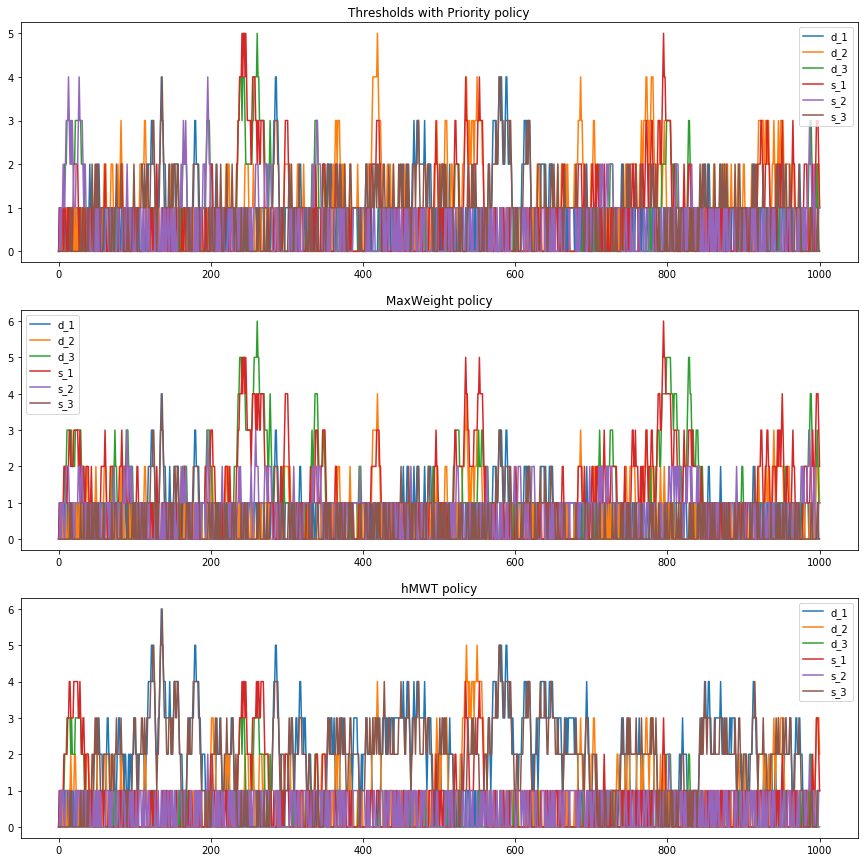

In [3]:
t = test_model.run(1000,P,plot=True)

12.385009527206421


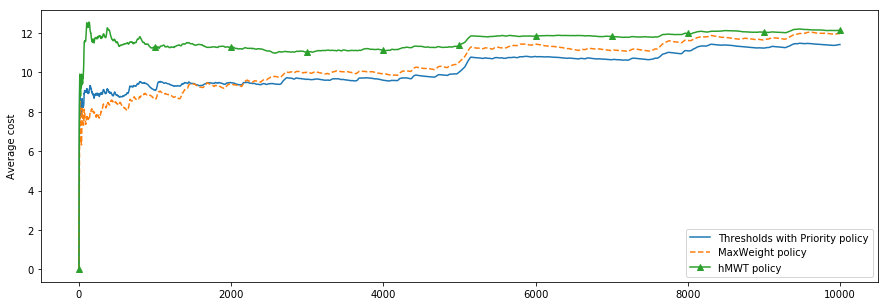

In [4]:
t = time.time()
N = 10000
c = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

In [ ]:

nb_iter=1000000
costs_traj = c[0]
plt.figure(figsize=(8,5))
linestyles = ['-', '--', '-^', ':']
for p, policy in enumerate(P):
    plt.plot(costs_traj[p],linestyles[p],label=str(policy),markevery=int(nb_iter/10.))
plt.legend(loc='best')
plt.ylabel('Average cost')

In [ ]:
t = time.time()
N = 1000000
c = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

In [ ]:
c[0]

### Normal arrival rates and high costs on middle nodes

In [ ]:
NN = MatchingGraph([(1,1),(1,2),(2,2),(2,3),(3,3)],3,3)
alpha = np.array([3./6., 2./6., 1./6.])
beta = np.array([1.75/6., 2.75/6., 1.5/6.])
arrival_dist = NodesData.items(alpha,beta,NN)
costs = NodesData(np.array([1., 3., 1., 1., 3., 1.]),NN)
P = [TwP_policy([0., 0., 1.]),TwMW_policy([0., 1.],costs),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(NN)
test_model = Model(NN,arrival_dist,costs,x0)

In [ ]:
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
N = 1000000
c, x = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

In [ ]:
c

### Asymptotic arrival rates and high costs on Workload

In [ ]:
NN = MatchingGraph([(1,1),(1,2),(2,2),(2,3),(3,3)],3,3)
alpha = np.array([3./6., 2./6., 1./6.])
beta = np.array([1.97/6., 2.97/6., 1.06/6.])
arrival_dist = NodesData.items(alpha,beta,NN)
costs = NodesData(np.array([1., 2., 3., 1., 2., 3.]),NN)
#P = [TwP_policy([0., 0., 9.]),TwMW_policy([0., 9.],costs),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
P = [TwP_policy([0., 0., 9.]),MaxWeight_policy(costs), hMWT_policy(NN,Workload_index=['d',(3,)], alpha=arrival_dist, costs=costs, beta=2., kappa=10., theta=1., delta_plus=0.01, NUmax=8.)]
x0 = State.zeros(NN)
test_model = Model(NN,arrival_dist,costs,x0)

In [ ]:
Pbis = [TwPbis_policy([0., 0., 9.])]

In [ ]:
t = test_model.run(1000,P,plot=True)

In [ ]:
t = time.time()
N = 1000000
c = test_model.average_cost(N,Pbis,plot=True)
print(time.time()-t)

In [ ]:
c[0]

In [ ]:
t = time.time()
N = 1000000
c = test_model.average_cost(N,P,plot=True)
print(time.time()-t)

In [ ]:

nb_iter=1000000
costs_traj = c[0]
plt.figure(figsize=(8,5))
linestyles = ['-', '--', '-^', ':']
for p, policy in enumerate(P):
    plt.plot(costs_traj[p],linestyles[p],label=str(policy),markevery=int(nb_iter/10.))
plt.legend(loc='best')
plt.ylabel('Average cost')

In [ ]:
c[0]

### Other tests

In [ ]:
NS = NodesData_wSlice(np.array([1., 0., 2., 3., 0.]),W)
NS[S]

In [ ]:
S = NodesSlice('d',np.array([1,3]))
S.index

In [ ]:
%lprun -f test_slice test_slice(True,100000)

In [ ]:
def test_slice(S,n):
    if S:
        N = NodesData_wSlice(np.array([1., 0., 2., 3., 0.]),W)
    else:
        N = NodesData(np.array([1., 0., 2., 3., 0.]),W)
        
    for _ in range(n):
        s = NodesSlice('d',np.array([1,3]))
        a = N[s]

In [ ]:
class NodesSlice:
    def __init__(self, t, index):
        self.t = t
        self.index = index

class NodesData_wSlice(NodesData):
    
    def __getitem__(self, key):
        if isinstance(key, NodesSlice):
            if key.t == 'd':
                return self.data[key.index-1]
            else:
                return self.data[key.index+self.matchingGraph.nb_demand_classes-1]
        else:
            i, j = key
            return self.data[[i-1, j+self.matchingGraph.nb_demand_classes-1]]
    